In [1]:
import cv2
import numpy as np
import time
import threading

from src.display import showarray
from src.feed import LiveFrameProcessor
from src.video import VideoHandler
from src.processing.analyzers import DiceAnalyzer
from src.processing import features

In [2]:
dice_mon = cv2.imread("Medium_1_0.jpg")

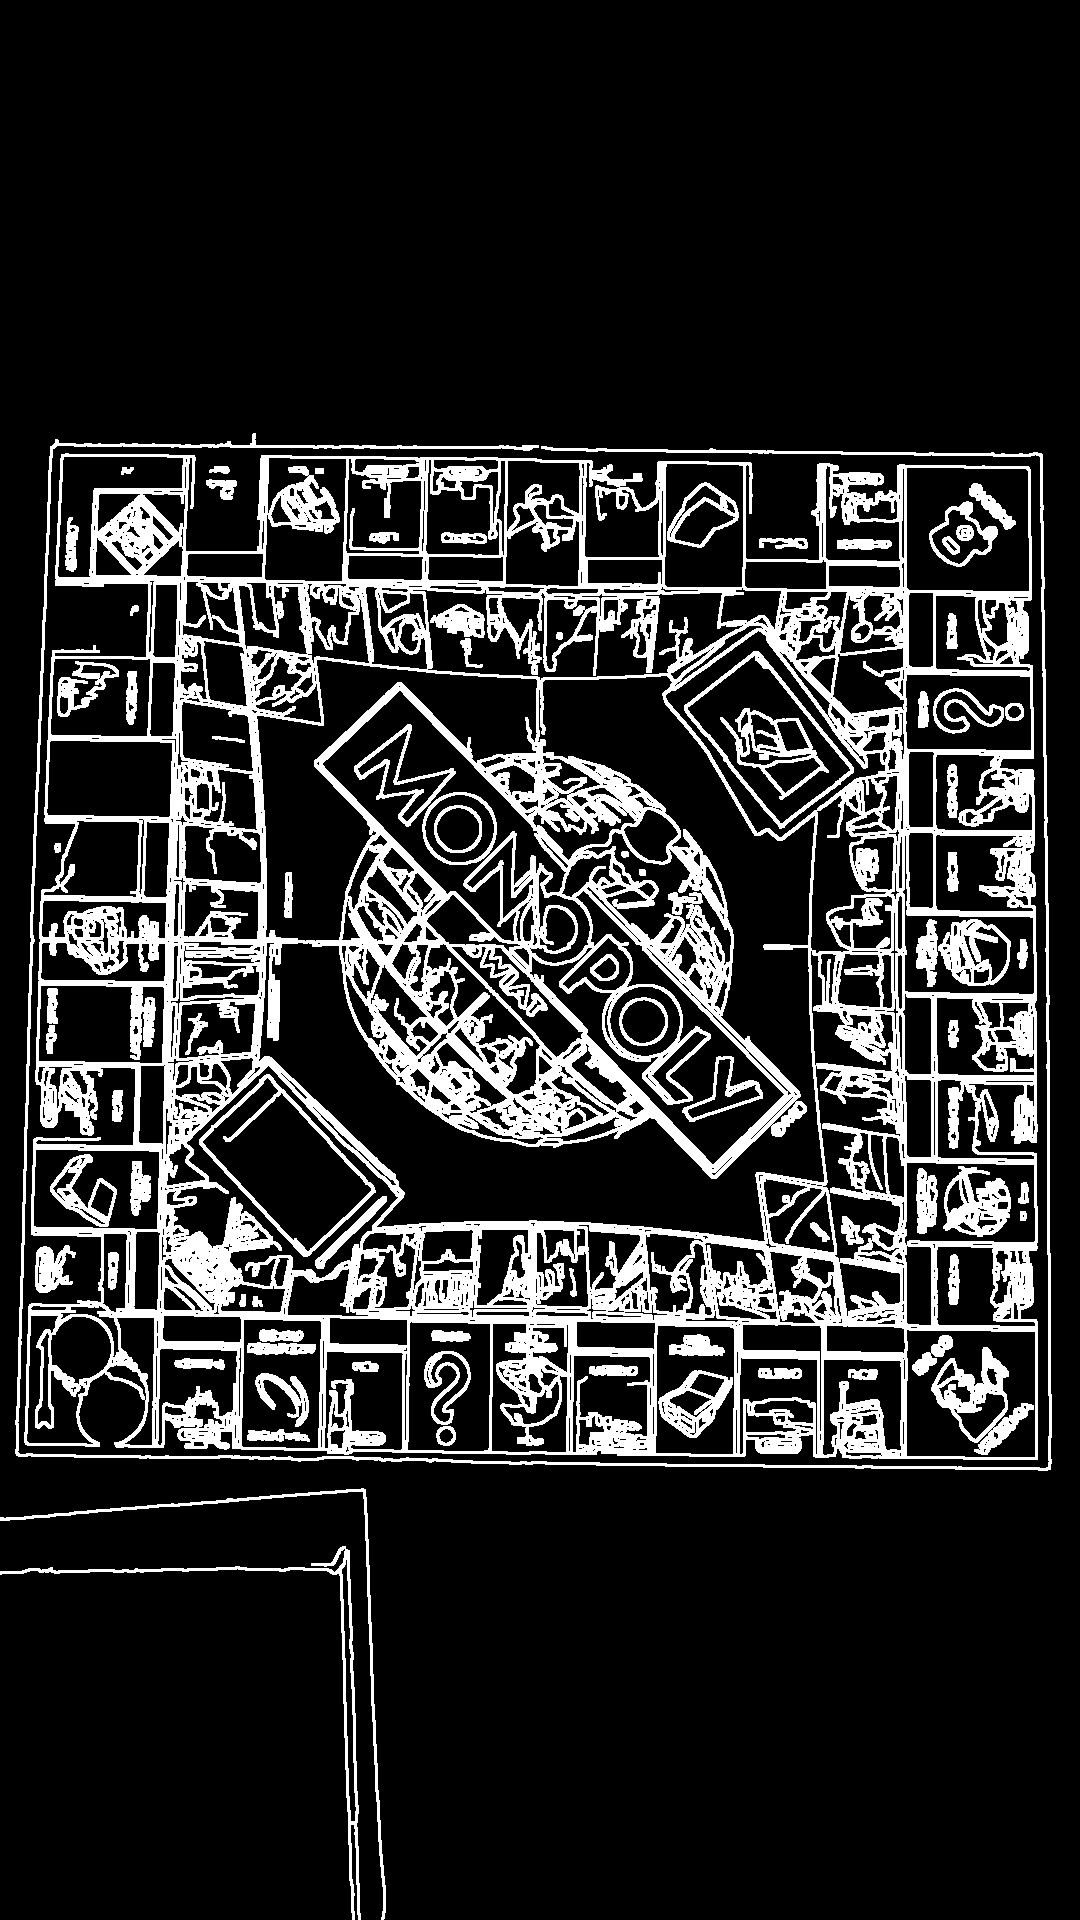

In [3]:
dice_mon_edges = features.get_clear_edges(dice_mon)
showarray(dice_mon_edges)

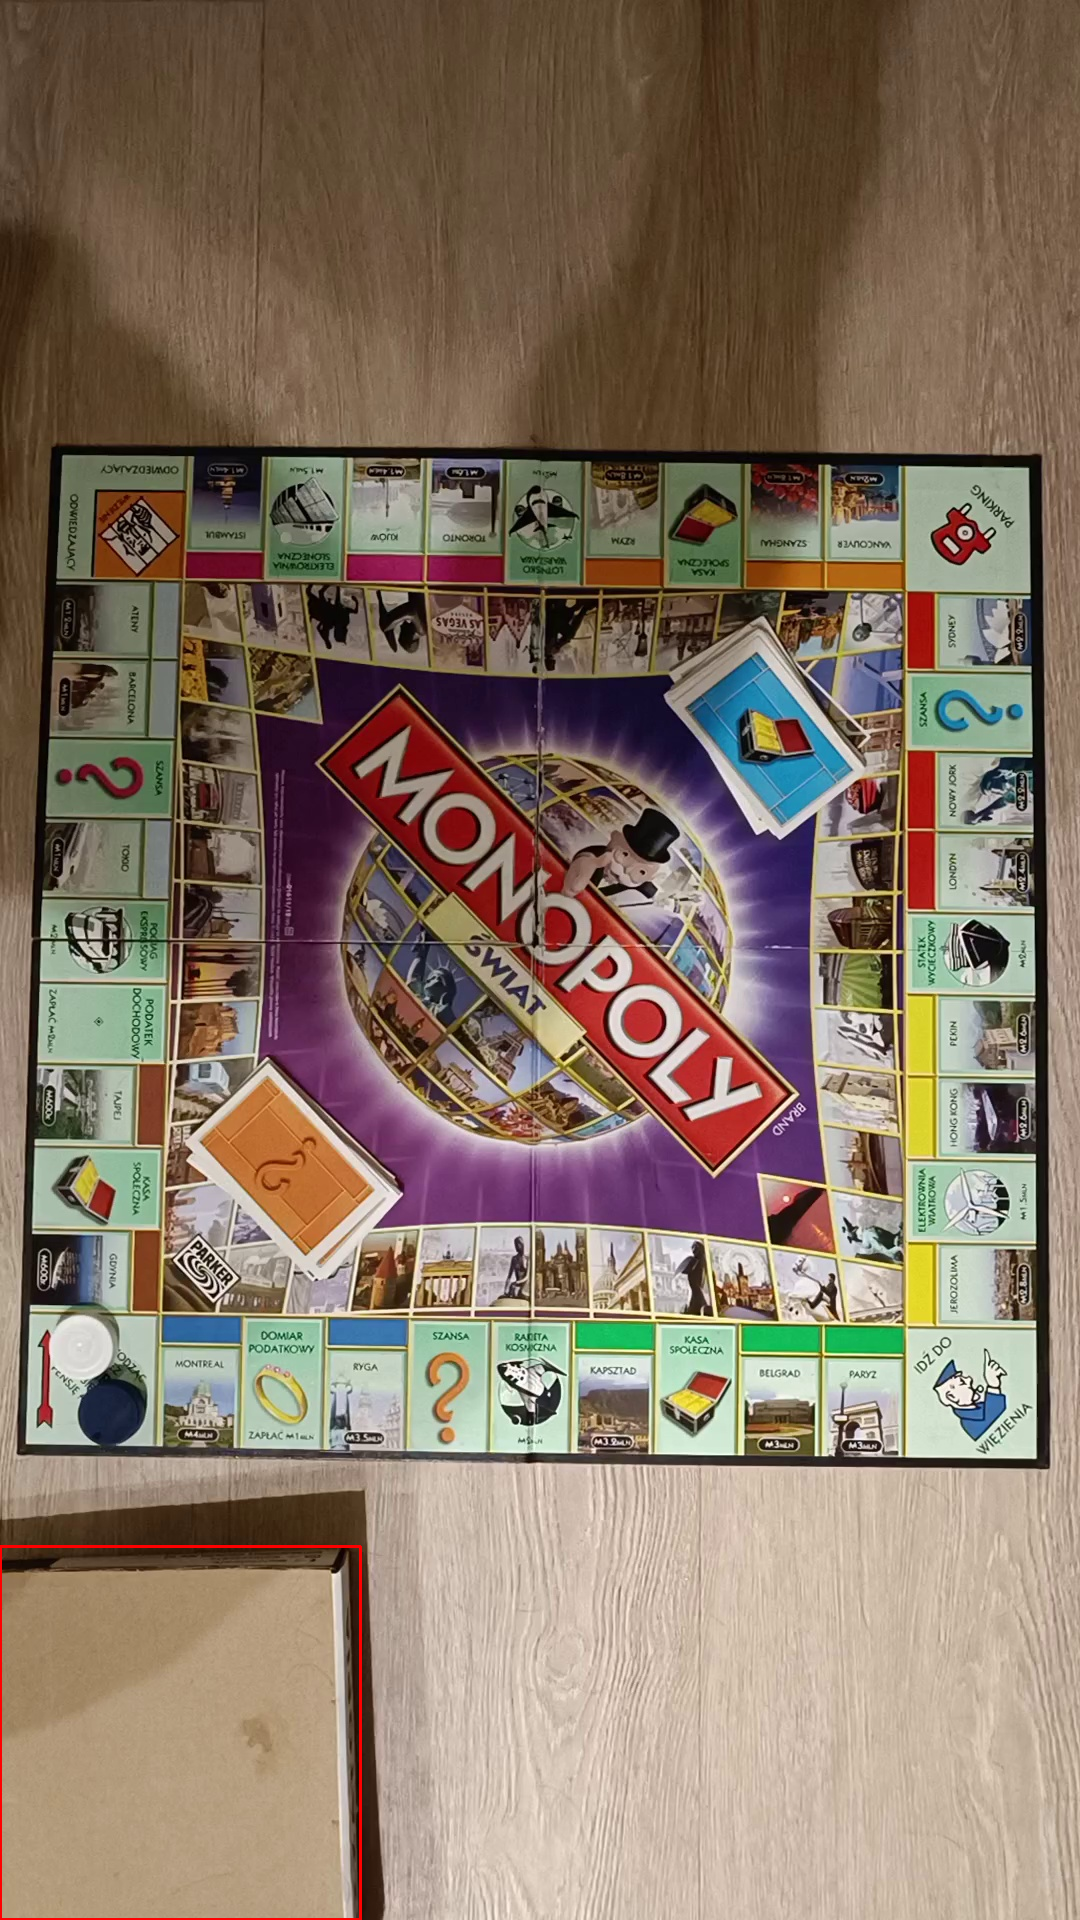

In [4]:
dice_area_rect = features.find_dice_throwing_area(dice_mon)

showarray(cv2.rectangle(dice_mon.copy(), dice_area_rect, (0, 0, 255), 2))

In [5]:
def get_dice_detector() -> cv2.SimpleBlobDetector:
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 25
    params.maxArea = 60
    params.filterByCircularity = True
    params.minCircularity = 0.6
    params.filterByColor = True
    params.filterByConvexity = True
    params.minConvexity = 0.8
    params.filterByInertia = True
    params.minInertiaRatio = 0.7
    return cv2.SimpleBlobDetector_create(params)

dice_detector = get_dice_detector()

In [8]:
analyzer = DiceAnalyzer(dice_detector, threaded=True)
processor = LiveFrameProcessor("feed", 800, 400)
with VideoHandler("data/recordings/Easy_2.mp4") as vh:
    initial_frame = vh.get_frame(0)
    additional_context = {
        "dice_area_rect": features.find_dice_throwing_area(initial_frame)
    }
    vh.go_through_video(processor, [analyzer], additional_context=additional_context)

{'video_name': 'Easy_2', 'frame_number': 0, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0}
{'video_name': 'Easy_2', 'frame_number': 1, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 8.72083643111088}
{'video_name': 'Easy_2', 'frame_number': 2, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 29.758362102798277}
{'video_name': 'Easy_2', 'frame_number': 3, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 23.670992132052273}
{'video_name': 'Easy_2', 'frame_number': 4, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 26.63257697313615}
{'video_name': 'Easy_2', 'frame_number': 5, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 29.972515175742565}
{'video_name': 'Easy_2', 'frame_number': 6, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 28.72960550630126}
{'video_name': 'Easy_2', 'frame_number': 7, 'dice_area_rect': (0, 0, 359, 351), 'dice_dots': 0, 'fps': 31.735453257063924}
{'video_name': 'Easy_2', 'frame_number': 8, 'di